# Forecasting Extreme Space Weather Over Time

In [ ]:
import numpy
import pandas
from matplotlib import pyplot
import matplotlib
import datetime
import scipy.signal
import scipy.stats
from typing import List, Tuple
import sklearn.utils
import requests
from bs4 import BeautifulSoup
from abc import abstractmethod

# set plot characteristics
%matplotlib inline
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 25}
matplotlib.rc('font', **font)

# Import and wrangle data

In [ ]:
df = pandas.read_fwf('/Users/isaacfinberg/Downloads/1-hour_USGS_Dst.txt')

In [ ]:
df.head()

,Year,Mon,Day,Hr,DOY from start,Fractional DOY,Fractional year,Dst,HER,KAK,HON,SJG,sigma
0,1958,1,1,1,1.020833,1.020833,1958.000057,-113.6,-126.4,-86.1,-89.0,-152.8,31.9
1,1958,1,1,2,1.062500,1.062500,1958.000171,-104.3,-117.3,-78.4,-90.4,-130.9,24.1
2,1958,1,1,3,1.104167,1.104167,1958.000285,-98.1,-83.1,-85.0,-94.9,-129.1,21.4
3,1958,1,1,4,1.145833,1.145833,1958.000400,-116.4,-88.6,-106.1,-120.6,-150.2,26.1
4,1958,1,1,5,1.187500,1.187500,1958.000514,-119.9,-64.6,-120.5,-141.8,-152.6,39.2


In [ ]:
df.loc[:, 'Hr'] -= 1
df.loc[:, 'Dst'] = numpy.abs(df['Dst'].values)

In [ ]:
df['Date'] = [datetime.datetime(y, m, d, h) for y, m, d, h in zip(df['Year'].values, df['Mon'].values, 
                                                                  df['Day'].values, df['Hr'].values)]
df['Date'] = pandas.DatetimeIndex(df['Date'])

# Data visualization

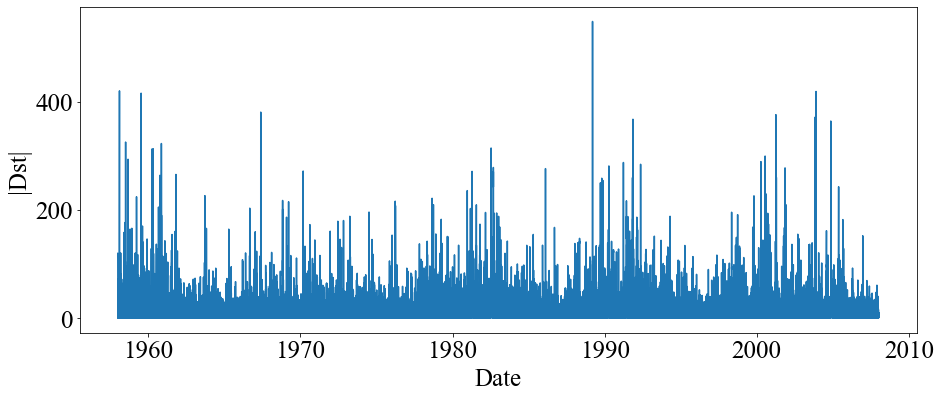

In [ ]:
pyplot.figure(figsize=(15,6))
pyplot.plot(df['Date'], df['Dst'])
pyplot.ylabel('|Dst|')
pyplot.xlabel('Date');

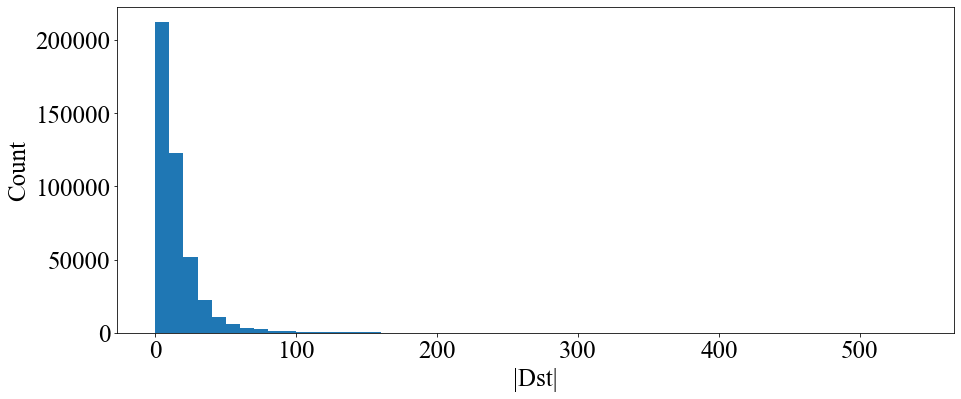

In [ ]:
pyplot.figure(figsize=(15,6))
pyplot.hist(df['Dst'], bins=numpy.arange(0, 550, 10))
pyplot.ylabel('Count')
pyplot.xlabel('|Dst|');

# Extreme value sampling

Use the two main approaches to sample extreme values: Peaks over threshold, block maxima.
Time will be taken in later sections of the report to evaluate the hyper paramters of these 
methods and compare the two methods.

## Peak over threshold method

In [ ]:
class PeakOverThresholdSampler(DistributionBuilder):

    def __init__(self, data: List[float]) -> None:
        
        self.data = data
        self.thresholds = numpy.arange(0, max(data) + 1)
        self.dist_obj = scipy.stats.genpareto
    
    def sample_pot(self, threshold: float) -> List:

        sample = [i for i in self.data if i > threshold]

        return sample

    def get_mean_excess(self, alpha: float = 0.95) -> Tuple[List[float], List[Tuple[float]]]:

        e_hats, CIs = [], []
        for threshold in self.thresholds[:-1]:
            extremes = self.sample_pot(threshold)
            mean = numpy.mean(extremes)   
            if len(extremes) < 2: 
                ci = (mean, mean)
            else:
                ci = scipy.stats.t.interval(alpha=alpha, df=len(extremes)-1, loc=mean, scale=scipy.stats.sem(extremes)) 
            e_hats.append(mean - threshold)
            CIs.append((ci[0]-threshold, ci[1]-threshold))           
        e_hats.append(0)
        CIs.append((0,0))
        return e_hats, CIs
    
    def get_params_excess(self, skip: int) -> Tuple[List[Tuple[float]], List[float]]:
        
        params = []
        thresholds = self.thresholds[::skip]
        for threshold in thresholds:
            extremes = self.sample_pot(threshold)
            if len(extremes) < 2:
                paramset = (0, 0, 0)
            else:
                paramset = self.fit(extremes)
            params.append(paramset)
            
        return params, thresholds
        
    def get_params_excess_CI(self, skip: int, alpha: float = 0.95) -> Tuple[List[Tuple[float]], List[Tuple[float]], List[float]]:
        
        def CI(param, cov):
            ci = (param - 2*cov, param + 2*cov)
            return ci
        
        params, CIs = [], []
        thresholds = self.thresholds[::skip]
        for threshold in thresholds:
            extremes = self.sample_pot(threshold)
            if len(extremes) < 2:
                paramset = (0, 0, 0)
                ci_dict = {'Shape':(0,0), 'Location':(0,0), 'Scale':(0,0)}
            else:
                fig, ax = pyplot.subplots() 
                nbins = round(max(extremes))
                n, bins, _ = ax.hist(x, nbins, density=True, alpha = 0.5, label='before');
                pyplot.close()
                centers = (0.5*(bins[1:]+bins[:-1]))
                paramset, cov = scipy.optimize.curve_fit(lambda extremes, shape, loc, scale : scipy.stats.genpareto.pdf(extremes, shape, 
                                                    loc=loc, scale=scale), centers, n)
                perr = numpy.sqrt(numpy.diag(cov))
                ci_dict = {'Shape':CI(paramset[0], perr[0]), 'Location':CI(paramset[1], perr[1]), 
                           'Scale':CI(paramset[2], perr[2])}
                print(ci_dict)
            params.append(paramset) 
            CIs.append(ci_dict)
            
        return params, CIs, thresholds
                

    def plot_mean_excess(self, alpha=0.95) -> None:

        means, CIs = self.get_mean_excess()
        lower_ci, upper_ci = [i[0] for i in CIs], [i[1] for i in CIs]
        pyplot.figure(figsize=(15,6))
        pyplot.plot(self.thresholds, means, color='red')
        pyplot.plot(self.thresholds, lower_ci, '--', color='gray')
        pyplot.plot(self.thresholds, upper_ci, '--', color='gray')
        pyplot.xlabel('Threshold')
        pyplot.ylabel('Mean Excess')
        
    def plot_parameter_stability(self, skip: int, with_CI=True) -> None:
        
        if with_CI:
            params, CIs, thresholds = self.get_params_excess_CI(skip)
        else:
            params, thresholds = self.get_params_excess(skip)
        param_names = ['Shape', 'Location', 'Scale']
        for j, param_name in enumerate(param_names):
            param = [i[j] for i in params]
            pyplot.figure(figsize=(15,6))
            pyplot.plot(thresholds, param, 'o-', color='red')
            if with_CI:
                lower_ci, upper_ci = [i[param_name][0] for i in CIs], [i[param_name][1] for i in CIs]
                pyplot.plot(thresholds, lower_ci, '--', color='gray')
                pyplot.plot(thresholds, upper_ci, '--', color='gray')
            pyplot.xlabel('Threshold')
            pyplot.ylabel(param_names[j])
            pyplot.tight_layout()
            pyplot.savefig('./figs/' + param_name + '.jpg')
            

In [ ]:
pot_sampler = PeakOverThresholdSampler(df['Dst'].to_list())

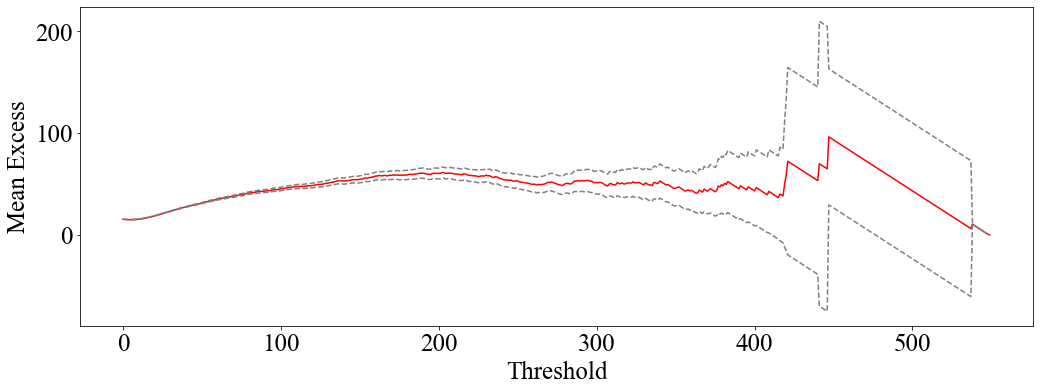

In [ ]:
pot_sampler.plot_mean_excess()
pyplot.tight_layout()
pyplot.savefig('./figs/mean_excess.jpg')

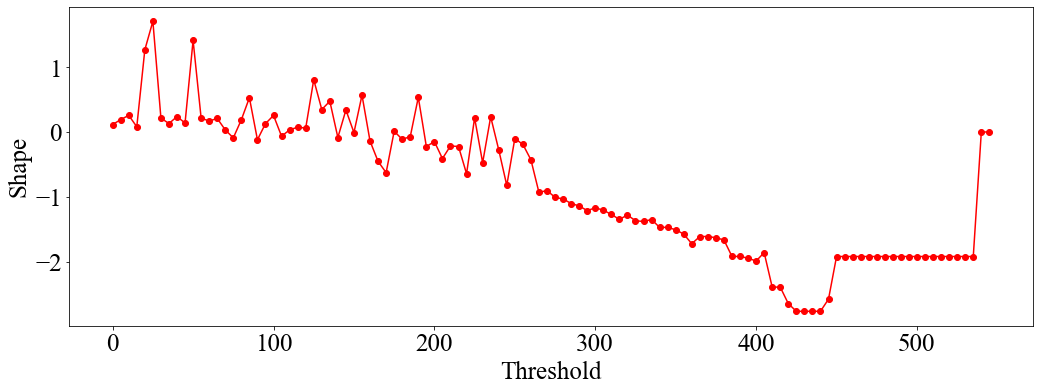

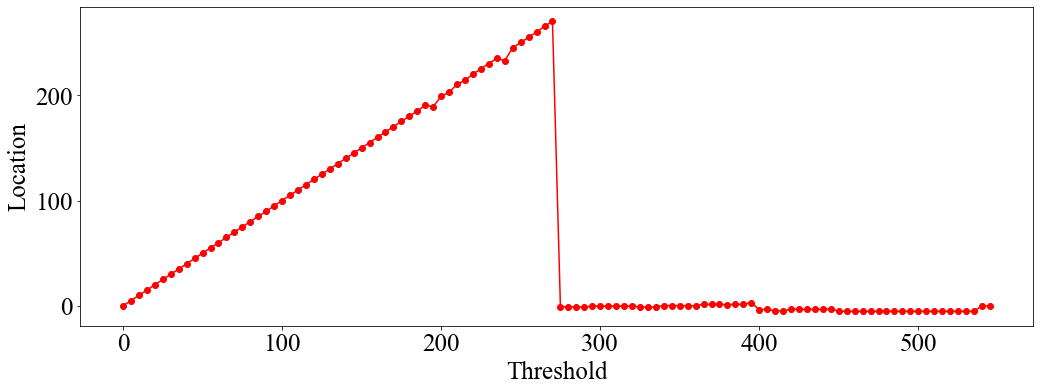

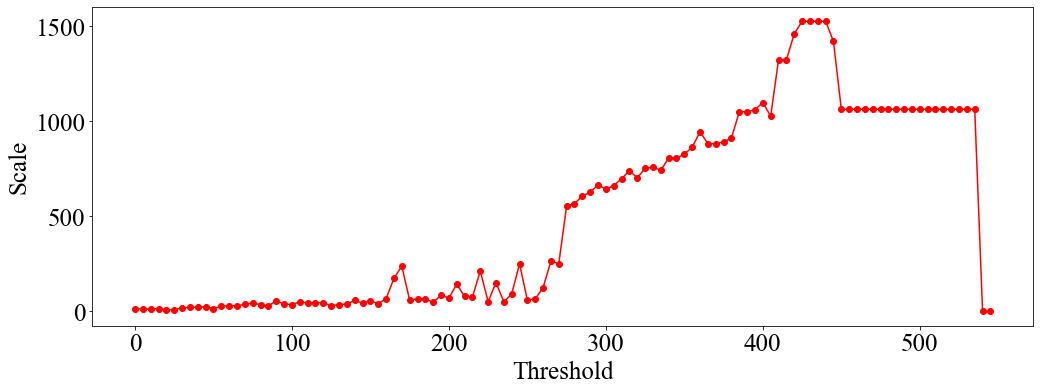

In [ ]:
pot_sampler.plot_parameter_stability(5, with_CI=False)

In [ ]:
threshold = 260
extremes_pot = pot_sampler.sample_pot(threshold)
params_pot = pot_sampler.fit(data=extremes_pot)
print(params_pot)

(-0.42857520596950605, 260.19999972902065, 124.50925921873164)


In [ ]:
class BlockMaximaSampler(DistributionBuilder):
    
    def __init__(self, data: pandas.DataFrame) -> None:
        
        self.data = data
        self.dist_obj = scipy.stats.genextreme
        
    def sample_bmm(self, block: str) -> List[float]:
        
        if block == 'year':
            pd_blocks = pandas.Series([i.year for i in self.data['Date'].to_list()])
        elif block == 'month':
            pd_blocks = pandas.Series([datetime.datetime(i.year, i.month, 1) for i in self.data['Date'].to_list()])
        blocks = list(set(pd_blocks.to_list()))
        maxs = []
        for block in blocks:
            if block == 'month':
                block_dst = self.data['Dst'][(pd_blocks.year == block.year) & (pd_blocks.month == block.month)]
            else:
                block_dst = self.data['Dst'][pd_blocks == block]
            block_max = block_dst.max()
            maxs.append(block_max)
            
        return maxs

In [ ]:
bmm_sampler = BlockMaximaSampler(df)

In [ ]:
extremes_bmm = bmm_sampler.sample_bmm('year')
params_bmm = bmm_sampler.fit(extremes_bmm)
print(params_bmm)

(-0.02940570256976676, 178.63011654307093, 79.28601664488815)


# Determine IID status  

Use a frequency domain trasform to establish any cyclic components of the time series that 
may negate an assumption of IID data points. Extreme Value Theory relies on the IID assumption, 
and it is noted in the literature that there is some seasonality behavior in the data due to 
solar cycles, so steps may need to be taken to separate the data into groups of IID data points.

In [ ]:
def get_annual_max(data: pandas.DataFrame) -> List[float]:
    
    pd_years = pandas.Series([i.year for i in data['Date'].to_list()])
    years = list(set(pd_years.to_list()))
    maxs = []
    for year in years:
        year_dst = data['Dst'][pd_years == year]
        annual_max = year_dst.max()
        maxs.append(annual_max)
        
    return years, maxs
    
years, maxs = get_annual_max(df)

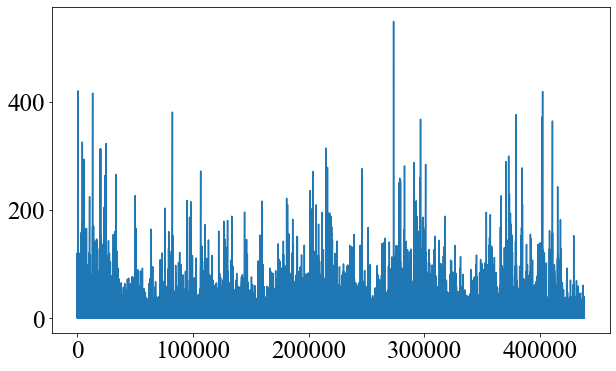

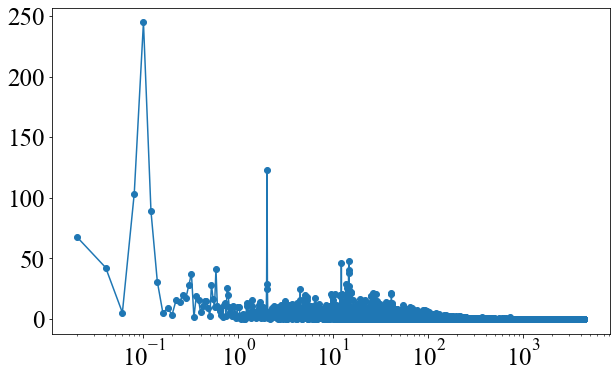

In [ ]:
freq, Pxx = scipy.signal.periodogram(df['Dst'].values, fs=8760, window='hamming')
pyplot.figure(figsize=(10,6))
pyplot.plot(df['Dst'].values, '-')
pyplot.figure(figsize=(10,6))
pyplot.plot(freq[1:], Pxx[1:], 'o-')
pyplot.xscale('log')

In [ ]:
def scrape_wiki_table() -> pandas.DataFrame:

    wikiurl = "https://en.wikipedia.org/wiki/List_of_solar_cycles"
    table_class = "wikitable sortable jquery-tablesorter"
    response = requests.get(wikiurl)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table',{'class':"wikitable"})
    df = pandas.read_html(str(table))
    df = pandas.DataFrame(df[0])

    return df

def get_dst_by_solar_cycle(data: pandas.DataFrame) -> List[str]:

    df = scrape_wiki_table()
    cycle_starts = df['Start (Minimum)'].dropna().to_list()
    years = numpy.array([i.year for i in data['Date'].to_list()])
    dst_start_record = min(years)
    cycle_starts = [i for i in cycle_starts if int(i.split('-')[0]) > dst_start_record]
    cycle_starts = pandas.DatetimeIndex(cycle_starts)
    columns = ['20', '21', '22', '23', '24']
    dst_df = {}
    date_df = {}
    prev_start = cycle_starts[0]
    for i, cycle_start in enumerate(cycle_starts[1:]):
        in_cycle = data.loc[(data['Date'] >= prev_start) & (data['Date'] < cycle_start), :]
        dst_df[columns[i]] = in_cycle['Dst'].to_list()
        date_df[columns[i]] = in_cycle['Date'].to_list()
        prev_start = cycle_start

    return dst_df, date_df

dst_by_cycle, date_by_cycle = get_dst_by_solar_cycle(df)
del dst_by_cycle['24']

In [ ]:
# for cycle in dst_by_cycle:
#     pot_sampler = PeakOverThresholdSampler(dst_by_cycle[cycle])
#     pot_sampler.plot_mean_excess()
#     pot_sampler.plot_parameter_stability(10, with_CI=False)

In [ ]:
# thresh = [125, 100, 175, 160]
# for i, cycle in enumerate(dst_by_cycle):
#     extremes_pot = pot_sampler.sample_pot(thresh[i])
#     params_pot = pot_sampler.fit(data=extremes_pot)
#     eval_pot = ModelEvaluator(params_pot, extremes_pot, scipy.stats.genpareto)
#     eval_pot.prob_plot()

In [ ]:
# for cycle in dst_by_cycle:
#     d = pandas.DataFrame(data={'Date':date_by_cycle[cycle], 'Dst':dst_by_cycle[cycle]})
#     bmm_sampler = BlockMaximaSampler(d)
#     extremes_bmm = bmm_sampler.sample_bmm('month')
#     params_bmm = bmm_sampler.fit(extremes_bmm)
#     print(params_bmm)
#     eval_bmm = ModelEvaluator(params_bmm, extremes_bmm, scipy.stats.genextreme)
#     eval_bmm.dist_plot()

# Distribution fitting

Use MLE to fit multiple extreme value distributions (Weibull, Gumbel, Frechet, etc.) to 
the two sampled datasets and evaluate the fit of the distributions

In [ ]:
class DistributionBuilder:
    
    
    def __init__(self, data: List[float], ScipyDistributionObj: object) -> None:
        
        self.data = data
        self.dist_obj = ScipyDistributionObj
        
    def fit(self, data=None) -> Tuple[str]:
        
        if isinstance(data, type(None)):
            shape, loc, scale = self.dist_obj.fit(self.data)
        else:
            shape, loc, scale = self.dist_obj.fit(data)
        
        return shape, loc, scale
    
    @abstractmethod
    def bootstrap(self, data, replicates=10000, rand_state=0) -> List[Tuple[float]]:
        
        params_bootstrap = []
        n_samples = len(data)
        for rep in range(replicates):
            sample = sklearn.utils.resample(data, replace=True, n_samples=n_samples, random_state=rand_state, 
                                        stratify=None)
            params = self.fit(data=sample)
            params_bootstrap.append(params)
            
        return params_bootstrap
    
    def bootstrap_params(self, data: List[float], CI_alpha=0.95) -> dict:
        
        params_bootstrap = self.bootstrap(data)
        def CI(param_bootstrap, CI_alpha):
            mean = numpy.mean(param_bootstrap)
            ci = stats.t.interval(alpha=CI_alpha, df=len(param_bootstrap)-1, loc=mean, 
                                  scale=stats.t.sem(param_bootstrap))   
            return mean, ci
        
        shape = [i[0] for i in params_bootstrap]
        loc = [i[1] for i in params_bootstrap]
        scale = [i[2] for i in params_bootstrap]
        shape_mu, shape_ci = CI(shape)
        loc_mu, loc_ci = CI(loc)
        scale_mu, scale_ci = CI(scale)
        paramset_CI = {'shape':{'mean':shape_mu, 'ci':shape_ci}, 'loc':{'mean':loc_mu, 'ci':loc_ci},
                      'scale':{'mean':scale_mu, 'ci':scale_ci}}
        
        return paramset_CI

# Evaluate Models

In [ ]:
class ModelEvaluator:
    
    def __init__(self, params: Tuple[float], extremes: List[float], ScipyDistributionObj: object) -> None:
        
        self.params = params
        self.extremes = extremes
        self.dist_obj = ScipyDistributionObj
        
    def prob_plot(self) -> None:
        
        pyplot.figure(figsize=(8,8))
        (osm, osr), (slope, intercept, r) = scipy.stats.probplot(self.extremes, sparams=self.params, dist=self.dist_obj, 
                                                        fit=True, plot=pyplot)
        ax_lims = [numpy.min(numpy.concatenate((osr, osm)))-50, numpy.max(numpy.concatenate((osr, osm)))+50]
        x, y = sum(ax_lims) / 2, sum(ax_lims) / 2 + 50
#         pyplot.text(x, y, 'slope = ' + str(numpy.round(slope, 2)) + ' intercept = ' + str(numpy.round(intercept, 2)))
        pyplot.xlim([200, 600])
        pyplot.ylim([200, 600])
#         pyplot.xticks(ticks=[0, 500, 1000], labels=[0, 500, 1000])
        corr = scipy.stats.pearsonr(osm, osr)
        pyplot.plot([ax_lims[0], ax_lims[0]], [ax_lims[1], ax_lims[1]], '-', color='gray')
        print('slope: ', slope, ', intercept: ', intercept, 'corr: ', corr)
    
    def dist_plot(self, bins) -> None:
        
        pyplot.figure(figsize=(15,6))
        pyplot.hist(self.extremes, bins=bins, density=True)
        pdf = self.dist_obj.pdf(numpy.linspace(0, max(self.extremes), 1000), self.params[0], loc=self.params[1], scale=self.params[2])
        pyplot.plot(numpy.linspace(0, max(self.extremes), 1000), pdf)
        pyplot.ylabel('Density')
        pyplot.xlabel('|Dst|')
        
    def cdf_plot(self) -> None:
        
        x = numpy.sort(self.extremes)
        y = numpy.arange(len(x))/float(len(x))
        cdf = self.dist_obj.cdf(numpy.linspace(0, max(self.extremes), 1000), self.params[0], loc=self.params[1], scale=self.params[2])
        pyplot.figure(figsize=(15,6))
        pyplot.plot(x, y)
        pyplot.plot(numpy.linspace(0, max(self.extremes), 1000), cdf)

In [ ]:
eval_pot = ModelEvaluator(params_pot, extremes_pot, scipy.stats.genpareto)

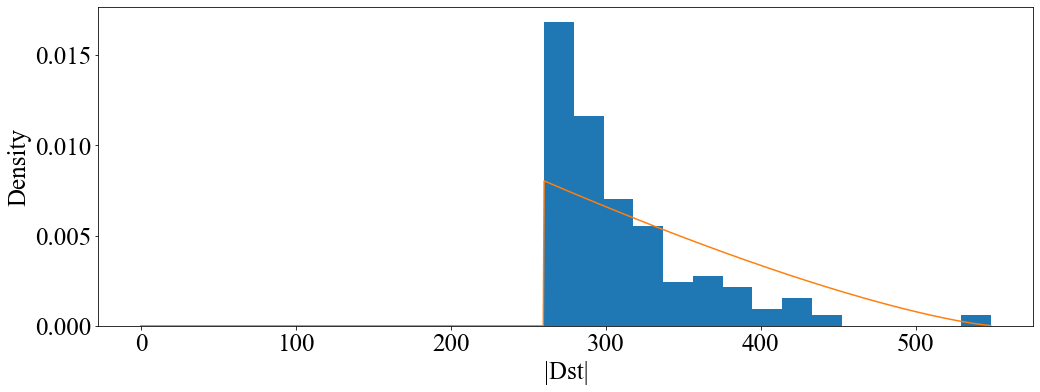

In [ ]:
eval_pot.dist_plot('auto')
pyplot.tight_layout()
pyplot.savefig('./figs/pot_dist.jpg')

slope:  0.7502231095832347 , intercept:  49.34142268516524 corr:  (0.956449158768162, 9.264229171227673e-92)


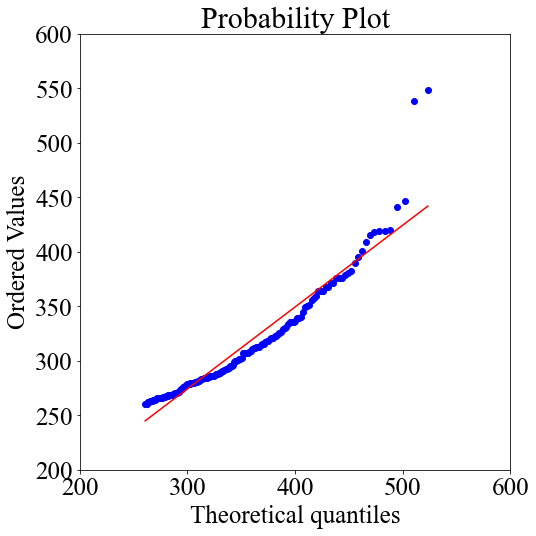

In [ ]:
eval_pot.prob_plot()
pyplot.tight_layout()
pyplot.savefig('./figs/pot_prob_plot.jpg')

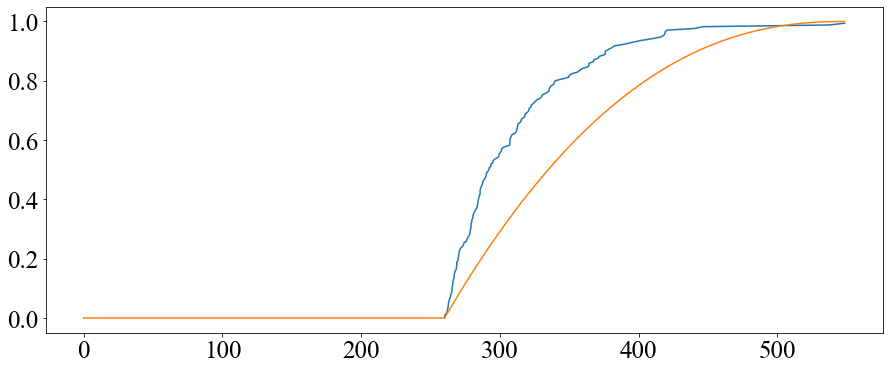

In [ ]:
eval_pot.cdf_plot()

In [ ]:
eval_bmm = ModelEvaluator(params_bmm, extremes_bmm, scipy.stats.genextreme)

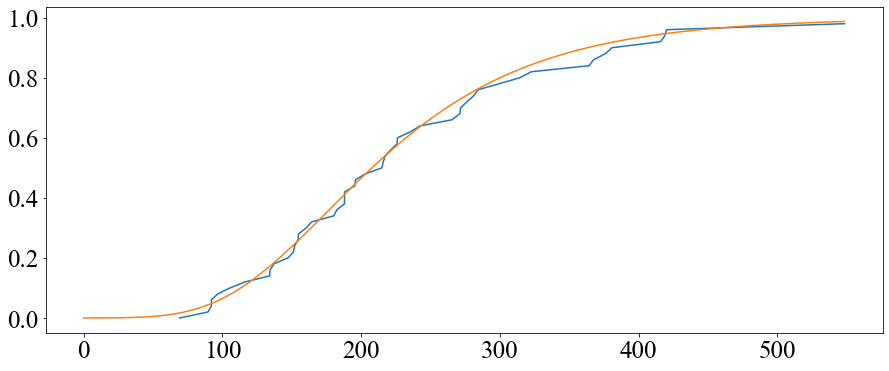

In [ ]:
eval_bmm.cdf_plot()

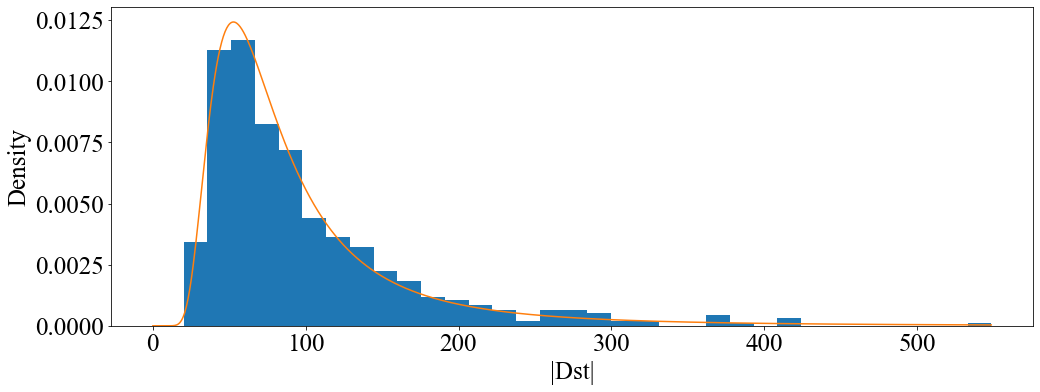

In [ ]:
eval_bmm.dist_plot('auto')
pyplot.tight_layout()
pyplot.savefig('month_bmm_dist.jpg')

slope:  1.0333690896035579 , intercept:  -5.73849454589913 corr:  (0.9939166499385146, 1.1857591881340068e-47)


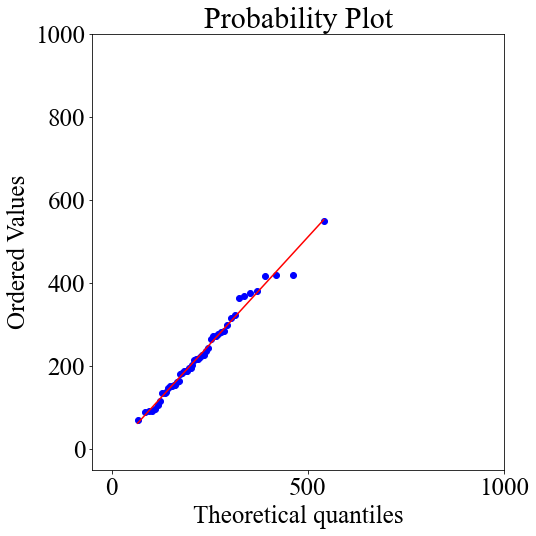

In [ ]:
eval_bmm.prob_plot()
pyplot.tight_layout()
pyplot.savefig('./figs/prob_plot.jpg')

# Return Levels and Periods

Calculate and evaluate the different return levels at several return periods among the 
different sampling and distribution fitting methods

In [ ]:
class Returns(DistributionBuilder):
    
    def __init__(self, params: Tuple[float], periods: List[int], ScipyDistributionObj: object) -> None:
        
        self.params = params
        self.periods = periods
        self.dist_obj = ScipyDistributionObj
        
    def get_return_levels(self, periods) -> List[float]:
        
        return_levels = []
        for period in periods:
            q = 1 - 1 / period
            return_levels.append(self.dist_obj.ppf(q, self.params[0], loc=self.params[1], scale=self.params[2]))
        
        return return_levels
    
    def get_CI(self, time_point: float, extremes: List[float], alpha=0.5) -> Tuple[float]:
        
        params = self.bootstrap(extremes, replicates=200)
        return_level = []
        for paramset in params:
            q = 1 - 1 / time_point
            return_level.append(self.dist_obj.ppf(q, paramset[0], loc=paramset[1], scale=paramset[2]))
        sort_level = numpy.sort(return_level)
        lower_ci = sort_level[int((len(sort_level) - 1) * alpha / 2)]
        upper_ci = sort_level[int((len(sort_level) - 1) * (1 - alpha / 2))]
        
        return (lower_ci, upper_ci)

    def plot_returns(self, ci_points: List[float], extremes: List[float]) -> None:
        
#         CIs = []
#         for point in ci_points:
#             CIs.append(self.get_CI(point, extremes))
#             print(point)
#         lower_CIs, upper_CIs = [i[0] for i in CIs], [i[1] for i in CIs]
        returns = numpy.array(self.get_return_levels(self.periods))
        periods = numpy.array(self.periods)
        periods = periods[returns > 0]
        returns = returns[returns > 0]
        pyplot.figure(figsize=(15,6))
        pyplot.plot(periods, returns)
#         pyplot.plot(ci_points, lower_CIs, '--', color='gray')
#         pyplot.plot(ci_points, upper_CIs, '--', color='gray')
        pyplot.xlabel('Return Period (Years)')
        pyplot.ylabel('Return Level (|Dst|)')

In [ ]:
periods = list(numpy.arange(1, 1100))

In [ ]:
returns_pot = Returns(params_pot, periods, scipy.stats.genpareto)

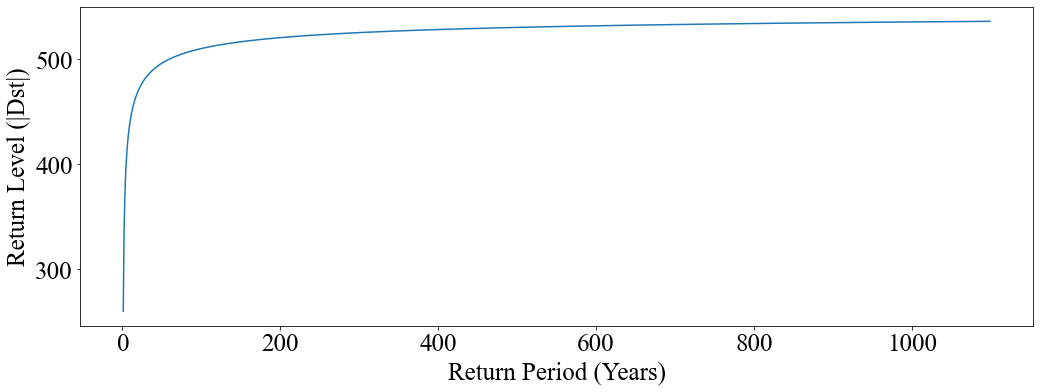

In [ ]:
returns_pot.plot_returns([110, 550, 1100], extremes_pot)
pyplot.tight_layout()
pyplot.savefig('./figs/return_level_pot.jpg')

In [ ]:
returns_pot.get_return_levels([110, 550, 1100])

[511.9679188690183, 531.277842410879, 536.2743245422037]

In [ ]:
returns_bmm = Returns(params_bmm, periods, scipy.stats.genextreme)

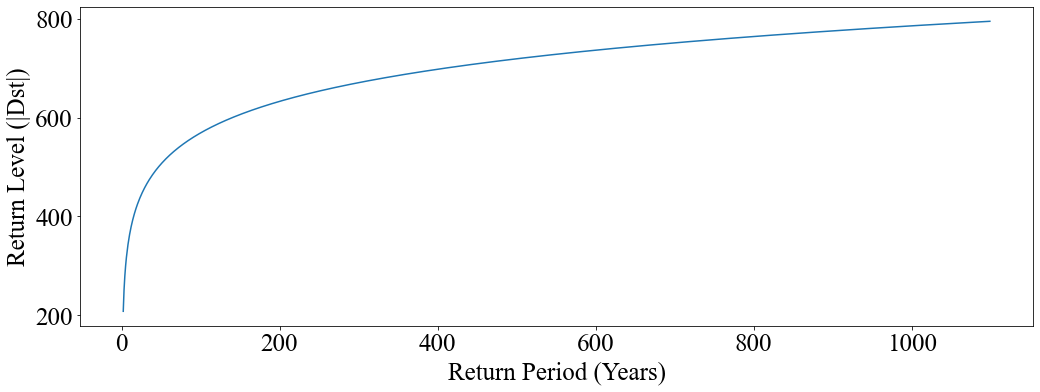

In [ ]:
returns_bmm.plot_returns([110, 550, 1100], extremes_bmm)
pyplot.tight_layout()
pyplot.savefig('./figs/return_level.jpg')

In [ ]:
returns_bmm.get_return_levels([110, 550, 1100])

[577.8822231388165, 728.254109657941, 795.136870588502]

In [ ]:
df[df['Date'] == datetime.datetime(1989, 3, 13, 23)]

,Year,Mon,Day,Hr,DOY from start,Fractional DOY,Fractional year,Dst,HER,KAK,HON,SJG,sigma,Date
273479,1989,3,13,23,11395.979167,72.979167,1989.197203,446.2,-363.3,-540.7,-434.6,9999.0,89.3,1989-03-13 23:00:00
